In [388]:
from collections import defaultdict, OrderedDict
import importlib
import glob
import os
import pickle
import time

from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.patches import ConnectionPatch, Patch, Rectangle
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

import filters
import utils
import visualization

visualization = importlib.reload(visualization)

In [389]:
FIGURES_PATH = './figures'
device = "cuda:0" if torch.cuda.is_available() else "cpu"

## RGC filters

In [205]:
class DifferenceOfGaussians(object):

    def __init__(self,
                 sigma1,
                 sigma2,
                 k,
                 kernel_size=17,
                 stride=1):
        self.sigma1 = sigma1
        self.sigma2 = sigma2
        self.k = k
        self.stride = stride
        filter_on = filters.center_surround(sigma1, sigma2, k, kernel_size)[None, None, :, :]
        filter_off = - filter_on
        self.filterbank = torch.cat([filter_on, filter_off], dim=0).to(device)

    def __call__(self, image):
        return torch.conv2d(image, self.filterbank, stride=self.stride)

torch.Size([2, 1, 25, 25])
torch.Size([2, 1, 25, 25])


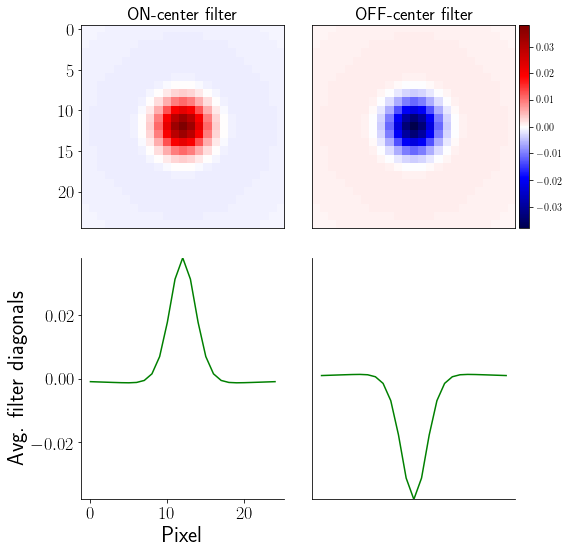

In [223]:
difference_of_gaussians = DifferenceOfGaussians(2, 14, 0.8, 25, 4)
visualization.plot_kernel(difference_of_gaussians.filterbank,
            vmin=torch.min(difference_of_gaussians.filterbank).item(),
            vmax=torch.max(difference_of_gaussians.filterbank).item(),
            kernel_name=['ON-center filter', 'OFF-center filter'],
            save_path=FIGURES_PATH)

## V1 filters

In [224]:
v1_filterbank = filters.v1_filters(
    filter_length=8,
    number_of_filters=8,
    pad_width=0,
    filter_type='double')
v1_rfs = torch.conv2d(
               difference_of_gaussians.filterbank.transpose(0, 1),
               v1_filterbank[:, :, :, :])

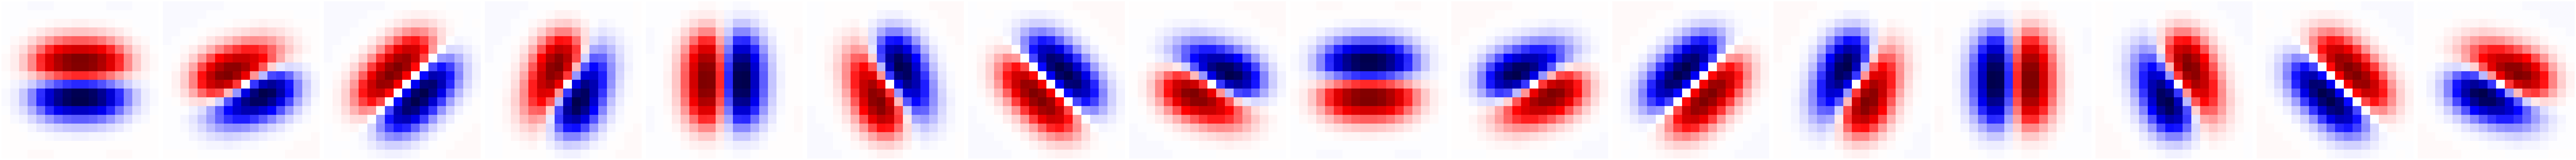

In [225]:
fig = visualization.plot_all_filters(v1_rfs)
fig.set_tight_layout(True)
fig.savefig(
    os.path.join(FIGURES_PATH, 'v1-rfs.pdf'))

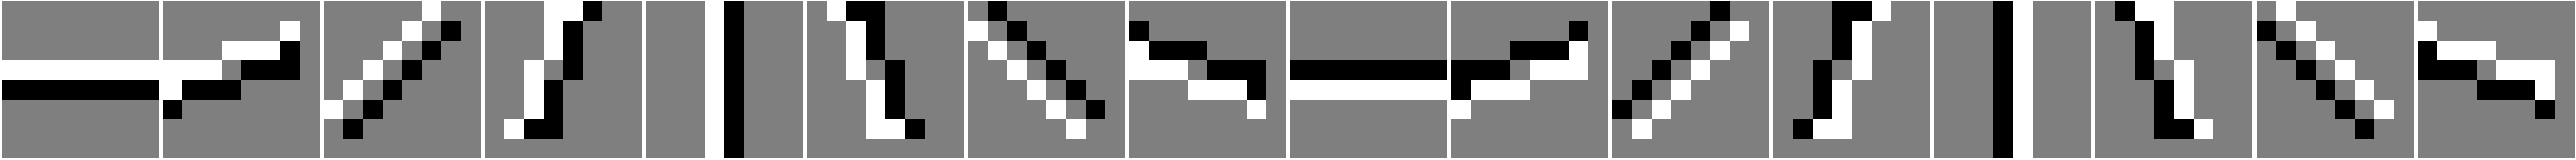

In [226]:
fig = visualization.plot_all_filters(
    v1_filterbank[:, 0, :, :] - v1_filterbank[:, 1, :, :],
    cmap='binary')
fig.set_tight_layout(True)
fig.savefig(os.path.join(FIGURES_PATH, 'v1-weights.pdf'))

## Model

In [227]:
class ReluBankWithBias(torch.nn.Module):

    def __init__(self, n_pathways: int) -> None:
        super().__init__()
        self.biases = torch.nn.Parameter(torch.Tensor(1, n_pathways, 1, 1))
        self.reset_parameters()

    def reset_parameters(self) -> None:
        torch.nn.init.zeros_(self.biases)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return torch.nn.functional.relu(x + self.biases)
    
class SlopedReluBankWithBias(torch.nn.Module):

    def __init__(self, n_pathways: int) -> None:
        super().__init__()
        self.slopes = torch.nn.Parameter(torch.Tensor(1, n_pathways, 1, 1))
        self.biases = torch.nn.Parameter(torch.Tensor(1, n_pathways, 1, 1))
        self.reset_parameters()

    def reset_parameters(self) -> None:
        torch.nn.init.ones_(self.slopes)
        torch.nn.init.zeros_(self.biases)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.slopes * torch.nn.functional.relu(x + self.biases)
    
class Pathway(torch.nn.Module):

    def __init__(
        self,
        v1_filterbank: torch.Tensor,
        n_pathways: int=2,
        feedback_unrolling_depth: int=2,
        feedback_factor: float=0.01,
        feedback_filter_len=10,
        learn_v1_filters: bool=False
      ) -> None:
        super().__init__()
        self.feedback_unrolling_depth = feedback_unrolling_depth
        self.feedback_factor = feedback_factor
        self.feedback_filter_len = feedback_filter_len
        self.retina_nonlinearity = SlopedReluBankWithBias(2)
        self.lgn = ReluBankWithBias(2)

        v1_out_channels, v1_in_channels, *self.v1_kernel_size = v1_filterbank.shape
        self.feedback_padding = (
            (self.feedback_filter_len + self.v1_kernel_size[0]) // 2 - 1,
            (self.feedback_filter_len + self.v1_kernel_size[1]) // 2 - 1)
        self.v1 = torch.nn.Sequential(OrderedDict([
                          ('linear', torch.nn.Conv2d(
                                             v1_in_channels,
                                             v1_out_channels,
                                             self.v1_kernel_size,
                                             bias=False)),
                          ('nonlinearity', SlopedReluBankWithBias(v1_out_channels))
                  ]))
        if not learn_v1_filters:
            with torch.no_grad():
                self.v1.linear.weight = torch.nn.Parameter(v1_filterbank)
        self.v1.linear.weight.requires_grad = learn_v1_filters

        self.feedback_kernel = torch.nn.Parameter(
                                       torch.Tensor(
                                           n_pathways,
                                           v1_in_channels,
                                           self.v1_kernel_size[0],
                                           self.v1_kernel_size[1]
                                       ))
        self.feedback_filter = torch.nn.Parameter(
            torch.Tensor(
                v1_in_channels,
                v1_out_channels,
                self.feedback_filter_len,
                self.feedback_filter_len
            ))
        
        self.reset_parameters()

    def reset_parameters(self):
        torch.nn.init.zeros_(self.feedback_kernel)
        torch.nn.init.zeros_(self.feedback_filter)
        self.lgn.reset_parameters()
        self.retina_nonlinearity.reset_parameters()
        self.v1.nonlinearity.reset_parameters()

    def forward_lgn(self, x: torch.Tensor) -> torch.Tensor:
        retina_output = self.retina_nonlinearity(x)
        feedforward_lgn_output = self.lgn(retina_output)
        feedforward_v1_output = self.v1(feedforward_lgn_output)
        lgn_output_list = [feedforward_lgn_output]
        v1_output_list = [feedforward_v1_output]
        for index in range(self.feedback_unrolling_depth - 1):
            feedback_contribution = torch.conv2d(
                v1_output_list[-1],
                self.feedback_filter,
                padding=self.feedback_padding)
            lgn_output = self.lgn(
                retina_output +
                self.feedback_factor * feedback_contribution)
            lgn_output_list.append(lgn_output)
            v1_output_list.append(self.v1(lgn_output))

        return lgn_output_list

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        retina_output = self.retina_nonlinearity(x)
        feedforward_v1_output = self.v1(self.lgn(retina_output))
        v1_output_list = [feedforward_v1_output]
        for index in range(self.feedback_unrolling_depth - 1):
            feedback_contribution = torch.conv2d(
                v1_output_list[-1],
                self.feedback_filter,
                padding=self.feedback_padding)
            v1_output_list.append(
                self.v1(
                    self.lgn(
                        retina_output +
                        self.feedback_factor * feedback_contribution)))

        return v1_output_list

## Objective function

In [228]:
class LogdetLoss(torch.nn.Module):

    def __init__(self, unfold_kernel_size=(1, 1)) -> None:
        super().__init__()
        self.unfold = torch.nn.Unfold(kernel_size=unfold_kernel_size)
        
    def forward(self, tensor: torch.Tensor) -> torch.Tensor:
        """
        Tensor shape
        (baches, channels, len_of_dim_1, len_of_dim_2)
        """
        
        vector = self.unfold(tensor)
        batches, channels, _ = vector.shape
        zero_mean_vector = vector - torch.mean(vector, 2).reshape(batches, channels, 1)
        per_batch_cov = torch.bmm(zero_mean_vector, torch.transpose(zero_mean_vector, 2, 1))
        return - torch.sum(torch.logdet(per_batch_cov))

## Natural Image

In [229]:
class NaturalImageDataset(Dataset):
    def __init__(self, image_paths, dog_transform):
        self.image_paths = image_paths
        self.dog_transform = dog_transform

    def transform(self, image):
        crop = transforms.CenterCrop(1100)
        gray = transforms.Grayscale()
        totensor = transforms.ToTensor()
        # image = TF.rotate(image, 45)
        image = gray(totensor(crop(image))).to(device)
        image = image - torch.mean(image)
        image = image[None, :, :, :]
        image = self.dog_transform(image)
        return image[0]

    def __getitem__(self, index):
        image = Image.open(self.image_paths[index])
        return self.transform(image)

    def __len__(self):
        return len(self.image_paths)

natural_image_dataset = NaturalImageDataset(glob.glob('data/*.jpg'), 
                                            difference_of_gaussians)

## Optimizaiton

In [230]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self, name, fmt=':f'):
        self.name = name
        self.fmt = fmt
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

    def __str__(self):
        fmtstr = '{name} {val' + self.fmt + '} ({avg' + self.fmt + '})'
        return fmtstr.format(**self.__dict__)

class ProgressMeter(object):
    def __init__(self, num_batches, meters, prefix=""):
        self.batch_fmtstr = self._get_batch_fmtstr(num_batches)
        self.meters = meters
        self.prefix = prefix

    def display(self, batch):
        entries = [self.prefix + self.batch_fmtstr.format(batch)]
        entries += [str(meter) for meter in self.meters]
        print('\t'.join(entries))

    def _get_batch_fmtstr(self, num_batches):
        num_digits = len(str(num_batches // 1))
        fmt = '{:' + str(num_digits) + 'd}'
        return '[' + fmt + '/' + fmt.format(num_batches) + ']'


In [465]:
number_iterations = 2500
natural_image_loader = DataLoader(natural_image_dataset, batch_size=1)
l1_params_range = torch.linspace(0.98, 0.996, 13)#[0.88, 0.92, 0.95, 0.98]#torch.linspace(0.6, 0.997, 40) #
measure_per_feedback_depth = {}
for unrolling_depth, learning_rate in [(1, 1e-4), (3, 1e-4)]:#, (5, 1e-5), (10, 1e-5)]:
    measures = defaultdict(list)
    measures['l1_param_range'] = l1_params_range
    for index, l1_param in enumerate(l1_params_range):
        print(f'lambda = {l1_param}')
        start = time.time()
        pathway = Pathway(v1_filterbank,
                              feedback_unrolling_depth=unrolling_depth,
                              feedback_factor=1.0,
                              feedback_filter_len = 28,
                              learn_v1_filters=False)
        pathway = pathway.to(device)
        unfold_kernel_size = (2,2)
        objective = LogdetLoss(unfold_kernel_size)

        regularization = lambda tensor:  (v1_filterbank.shape[0] *
                                          unfold_kernel_size[0] *
                                          unfold_kernel_size[1] *
                                          2 * torch.mean(tensor))
        optimizer = torch.optim.SGD(
            pathway.parameters(),
            lr=(l1_param**4) * learning_rate, momentum=0.0)
        scheduler = torch.optim.lr_scheduler.StepLR(
            optimizer, step_size=400, gamma=0.5)
        for index in range(number_iterations):
            losses = AverageMeter('Loss')
            batch_time = AverageMeter('Time')
            progress = ProgressMeter(
                len(natural_image_loader),
                [losses, batch_time],
                prefix="iter: [{}]".format(index))
            start = time.time()
            for i, image in enumerate(natural_image_loader):
                optimizer.zero_grad()
                pathway_output = pathway(image)
                objective_value = (1-l1_param) * objective(pathway_output[-1]) \
                                   + l1_param * regularization(pathway_output[-1])
                losses.update(objective_value, 1)
                objective_value.backward()
                optimizer.step()
            end = time.time()
            batch_time.update(end - start, 1)
            if index % 100 == 0:
                progress.display(i)
            scheduler.step()
        info_ff, info_fb, \
        firing_ff, firing_fb, \
        per_spike_info_ff, per_spike_info_fb, \
        retina_firing, lgn_firing = (0., 0., 0., 0., 0., 0., 0., 0.)
        with torch.no_grad():
            for i, image in enumerate(natural_image_loader):
                if i == 1:
                    continue
                pathway_output = pathway.forward(image)
                lgn_output = pathway.forward_lgn(image)
                info_fb -= objective(pathway_output[-1])
                info_ff -= objective(pathway_output[0])
                retina_firing += torch.mean(
                    pathway.retina_nonlinearity(image))
                lgn_firing += torch.mean(lgn_output[-1])
                firing_fb += torch.mean(pathway_output[-1])
                firing_ff += torch.mean(pathway_output[0])
                per_spike_info_fb += (
                    -objective(pathway_output[-1])/ 
                    torch.mean(pathway_output[-1]))
                per_spike_info_ff += (
                    -objective(pathway_output[0]) / 
                    torch.mean(pathway_output[0]))
            measures['feedback_filter'].append(pathway.feedback_filter)
            measures['retinal_firing_rate'].append(
                retina_firing / len(natural_image_loader))
            measures['lgn_firing'].append(
                lgn_firing / len(natural_image_loader))
            measures['firing_rate_fb'].append(
                firing_fb / len(natural_image_loader))
            measures['firing_rate_ff'].append(
                firing_ff / len(natural_image_loader))
            measures['information_fb'].append(
                info_fb / len(natural_image_loader))
            measures['information_ff'].append(
                info_ff / len(natural_image_loader))
            measures['per_spike_information_fb'].append(
                per_spike_info_fb / len(natural_image_loader))
            measures['per_spike_information_ff'].append(
                per_spike_info_ff / len(natural_image_loader))
    measure_per_feedback_depth[unrolling_depth] = measures

lambda = 0.9800000190734863
iter: [0][1/2]	Loss 3.577260 (4.006374)	Time 0.074379 (0.074379)
iter: [100][1/2]	Loss 0.135350 (-0.038775)	Time 0.066979 (0.066979)
iter: [200][1/2]	Loss -0.053325 (-0.244120)	Time 0.067119 (0.067119)
iter: [300][1/2]	Loss -0.183995 (-0.383981)	Time 0.067237 (0.067237)
iter: [400][1/2]	Loss -0.297776 (-0.497238)	Time 0.064498 (0.064498)
iter: [500][1/2]	Loss -0.343469 (-0.547482)	Time 0.067325 (0.067325)
iter: [600][1/2]	Loss -0.390989 (-0.595251)	Time 0.067188 (0.067188)
iter: [700][1/2]	Loss -0.439910 (-0.641265)	Time 0.067352 (0.067352)
iter: [800][1/2]	Loss -0.488095 (-0.687171)	Time 0.067237 (0.067237)
iter: [900][1/2]	Loss -0.507968 (-0.708553)	Time 0.066643 (0.066643)
iter: [1000][1/2]	Loss -0.530380 (-0.729333)	Time 0.065258 (0.065258)
iter: [1100][1/2]	Loss -0.552074 (-0.749655)	Time 0.070829 (0.070829)
iter: [1200][1/2]	Loss -0.574835 (-0.770500)	Time 0.064392 (0.064392)
iter: [1300][1/2]	Loss -0.583892 (-0.780284)	Time 0.068079 (0.068079)
iter: [

## Results

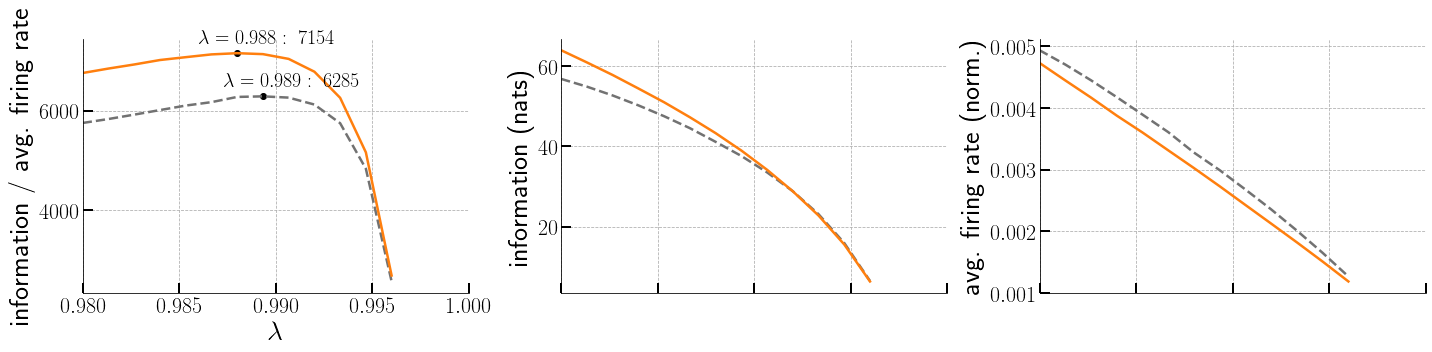

In [468]:
colors = {1: '#727272', 3: '#ff7f0e'}
show_max = True
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
for (unrolling_depth,
     measure_per_feedback) in measure_per_feedback_depth.items():
    xlim = [0.98, 1]
    if unrolling_depth == 1:
        linestyle = 'dashed'
    else:
        linestyle='-'

    ax = visualization.simple_plot(
        measure_per_feedback['l1_param_range'], 
        measure_per_feedback['per_spike_information_fb'],
        axes[0],
        ylabel='information / avg. firing rate',
        xlabel='$\lambda$',
        xlim=xlim,
        color=colors[unrolling_depth],
        linestyle=linestyle,
        linewidth=2.5)
    max_lambda_index = np.argmax(
        measure_per_feedback['per_spike_information_fb'])
    max_lambda = measure_per_feedback['l1_param_range'][max_lambda_index].cpu()
    max_info_per_spike = np.max(
        measure_per_feedback['per_spike_information_fb']).cpu()
    if show_max:
        text = f'$\lambda = {max_lambda:0.3f}:\;{max_info_per_spike:.0f}$'
        ax.text(max_lambda - (xlim[1] - xlim[0]) / 10,
            max_info_per_spike + 200, text, color="k", fontsize=20)
    ax.scatter(max_lambda, max_info_per_spike, color="k")
    ax = visualization.simple_plot(
        measure_per_feedback['l1_param_range'], 
        measure_per_feedback['information_fb'],
        ax = axes[1],
        ylabel='information (nats)',
        xlim=xlim,
        color=colors[unrolling_depth],
        linestyle=linestyle,
        linewidth=2.5)
    ax.xaxis.set_ticklabels([])
    ax = visualization.simple_plot(
        measure_per_feedback['l1_param_range'], 
        measure_per_feedback['firing_rate_fb'],
        ax=axes[2],
        ylabel='avg. firing rate (norm.)',
        xlim=xlim,
        color=colors[unrolling_depth],
        linestyle=linestyle,
        linewidth=2.5)
    ax.xaxis.set_ticklabels([])

fig.savefig(os.path.join(FIGURES_PATH, 'information_v1.pdf'))

In [477]:
info_per_spike_change = 100 * (
    max(measure_per_feedback_depth[3]['per_spike_information_fb']) / 
    max(measure_per_feedback_depth[1]['per_spike_information_ff']) - 1)
print(f'post feedback info per spike increased by {info_per_spike_change:2.2f}')

post feedback info per spike increased by 13.81


In [445]:
#with open('measure_per_feedback_depth_13.pickle', 'wb') as handle:
#    pickle.dump(measure_per_feedback_depth, handle, protocol=pickle.HIGHEST_PROTOCOL)
#with open('measure_per_feedback_depth_15.pickle', 'rb') as handle:
#    measure_per_feedback_depth = pickle.load(handle)

tensor(0.9880)


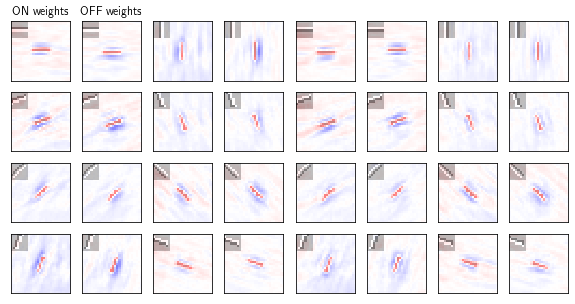

In [485]:
lambda_index = 6
measures_dict = measure_per_feedback_depth[3]
lam = measures_dict['l1_param_range'][lambda_index]
print(lam)
feedback_filter = measures_dict['feedback_filter'][lambda_index]

vmax = torch.max(torch.abs(feedback_filter))
vmin = -vmax
rotated_filters = []
fig, ax = plt.subplots(4, 8, figsize=(10, 5))
for i in range(pathway.v1.linear.weight.shape[0]):
    rotated_feedback_filter = transforms.functional.rotate(
        feedback_filter[:, i, :, :],
        -i * 360/feedback_filter.shape[1])
    rotated_filters.append(rotated_feedback_filter)

    ax1, ax2 = ax[i % 4, 2 * (i // 4): 2 * (i // 4) + 2 ]
    if i == 0:
        ax1.set_title('ON weights')
        ax2.set_title('OFF weights')
    v1_weights = utils.to_numpy(
        pathway.v1.linear.weight[i, 0, :, :] - pathway.v1.linear.weight[i, 1, :, :])
    v1_weights = np.pad(
        v1_weights, (feedback_filter.shape[-1] - v1_weights.shape[-1]) // 2)
    ax1.imshow(
        utils.to_numpy(
            pathway.v1.linear.weight[i, 0, :, :] - pathway.v1.linear.weight[i, 1, :, :]),
        plt.cm.gray)
    im = ax1.imshow(utils.to_numpy(feedback_filter[0, i, :, :]),
                 plt.cm.seismic,
                 alpha=0.5,
                 vmax = vmax,
                 vmin = vmin)
    ax2.imshow(
        utils.to_numpy(
            pathway.v1.linear.weight[i, 0, :, :] - pathway.v1.linear.weight[i, 1, :, :]),
        plt.cm.gray)
    ax2.imshow(
        utils.to_numpy(feedback_filter[1, i, :, :]),
                 plt.cm.seismic,
                 alpha=0.5,
                 vmax = vmax,
                 vmin = vmin)
    ax1.set_xticks([])
    ax1.set_yticks([])
    ax2.set_xticks([])
    ax2.set_yticks([])
    #fig.set_tight_layout(True)
    fig.savefig(
        f'figures/all_feedback_weights_{1000*lam:3.0f}.pdf',
        bbox_inches='tight', pad_inches=0.1)

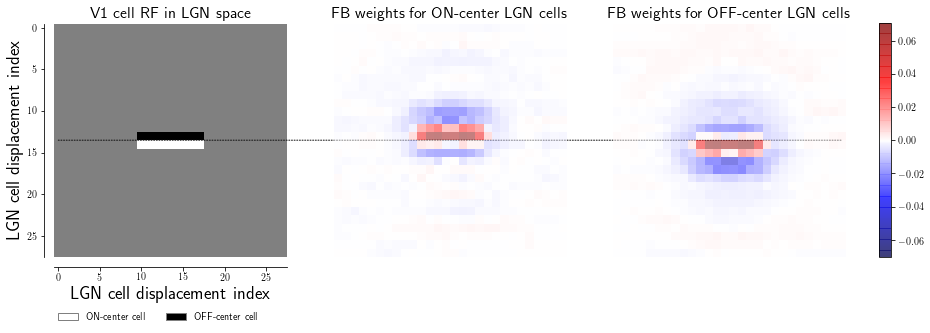

In [487]:
avg_feedback_filter = sum(rotated_filters)
vmax = torch.max(avg_feedback_filter).cpu().detach().numpy()
vmin = -vmax
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
v1_weights = utils.to_numpy(
    pathway.v1.linear.weight[0, 0, :, :] - pathway.v1.linear.weight[0, 1, :, :])
v1_weights = np.pad(
    v1_weights, (avg_feedback_filter.shape[-1] - v1_weights.shape[-1]) // 2)
v1_rf_img = ax[0].imshow(
    v1_weights,
    plt.cm.gray)
ax[0].spines['left'].set_position(('outward', 10))
ax[0].spines['bottom'].set_position(('outward', 10))
ax[0].set_ylabel('LGN cell displacement index', fontsize=18)
ax[0].set_xlabel('LGN cell displacement index', fontsize=18)
patches = [
    Rectangle(
        xy = (0, 10),
        width = 1,
        height = 1000,
        edgecolor='gray',
        facecolor=v1_rf_img.cmap(v1_rf_img.norm(np.max(v1_weights))),
        label='ON-center cell'),
    Rectangle(
        xy = (0, 10),
        width = 2,
        height = 1000,
        edgecolor='gray',
        facecolor=v1_rf_img.cmap(v1_rf_img.norm(-np.max(v1_weights))),
        label='OFF-center cell')]
ax[0].legend(
    handles=patches, bbox_to_anchor=(0, -0.22),
    loc=2, borderaxespad=0., ncol=2, edgecolor='w' )
# Hide the right and top spines
ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)
im = ax[1].imshow(utils.to_numpy(avg_feedback_filter[0, :, :]),
                 plt.cm.seismic,
                 alpha=0.5,
                 vmax = vmax,
                 vmin = vmin)
ax[1].set_axis_off()
ax[2].imshow(utils.to_numpy(avg_feedback_filter[1, :, :]),
                 plt.cm.seismic,
                 alpha=0.5,
                 vmax = vmax,
                 vmin = vmin)
ax[2].set_axis_off()
fig.colorbar(im, ax=ax.ravel().tolist(), orientation='vertical',fraction=0.014, pad=0.04)
ax[0].set_title('V1 cell RF in LGN space', fontsize=16)
ax[1].set_title('FB weights for ON-center LGN cells', fontsize=16)
ax[2].set_title('FB weights for OFF-center LGN cells', fontsize=16)
con = ConnectionPatch(xyA=(0, 13.5), xyB=(27, 13.5), coordsA='data', coordsB='data',
                      axesA=ax[0], axesB=ax[2], color='#101010', linestyle='dotted')
ax[0].add_artist(con)

#ax[3].set_title('ON weights - OFF weights', fontsize=16)
#plt.tight_layout()
fig.savefig(os.path.join(FIGURES_PATH, f'avg_feedback_weights_{1000*lam:3.0f}.pdf'))